In [1]:
import sys
import numpy as np
from astropy.io import fits
from aspired import image_reduction
from aspired import spectral_reduction

In [2]:
# Line list
atlas = [
    4193.5, 4385.77, 4500.98, 4524.68, 4582.75, 4624.28, 4671.23, 4697.02,
    4734.15, 4807.02, 4921.48, 5028.28, 5618.88, 5823.89, 5893.29, 5934.17,
    6182.42, 6318.06, 6472.841, 6595.56, 6668.92, 6728.01, 6827.32, 6976.18,
    7119.60, 7257.9, 7393.8, 7584.68, 7642.02, 7740.31, 7802.65, 7887.40,
    7967.34, 8057.258
]
element = ['Xe'] * len(atlas)

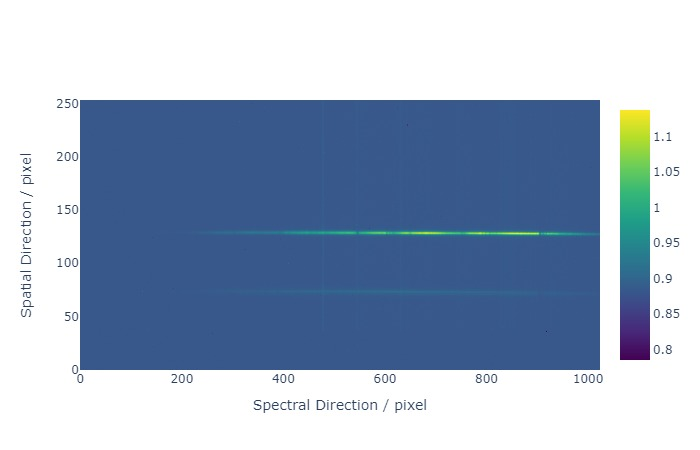

In [3]:
science_frame = image_reduction.ImageReduction('sprat_LHS6328.list')
science_frame.reduce()
science_frame.inspect(renderer='jpg')
#science_frame.savefits(overwrite=True)

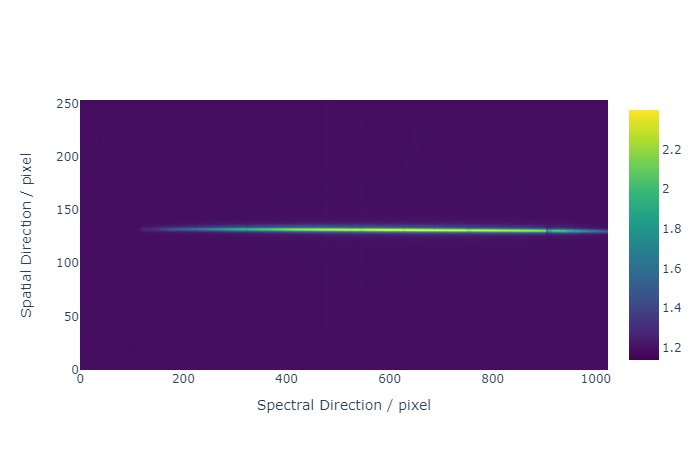

In [4]:
standard_frame = image_reduction.ImageReduction('sprat_Hiltner102.list')
standard_frame.reduce()
standard_frame.inspect(renderer='jpg')

In [5]:
# Set the spectral direction is defaulted to saxis=1
#saxis = 1

# initialise the two aspired.TwoDSpec()
lhs6328_twodspec = spectral_reduction.TwoDSpec(science_frame,
                                               cosmicray=True,
                                               readnoise=5.7)

hilt102_twodspec = spectral_reduction.TwoDSpec(standard_frame,
                                               cosmicray=True,
                                               readnoise=5.7)

ERROR:root:Please provide the variance in the same shape as the image.
ERROR:root:Please provide the variance in the same shape as the image.


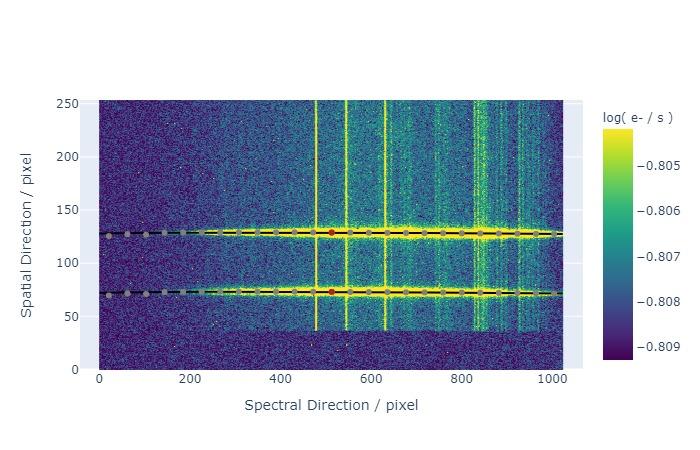

In [6]:
# automatically trace the spectrum
lhs6328_twodspec.ap_trace(nspec=2, display=True, renderer='jpg')

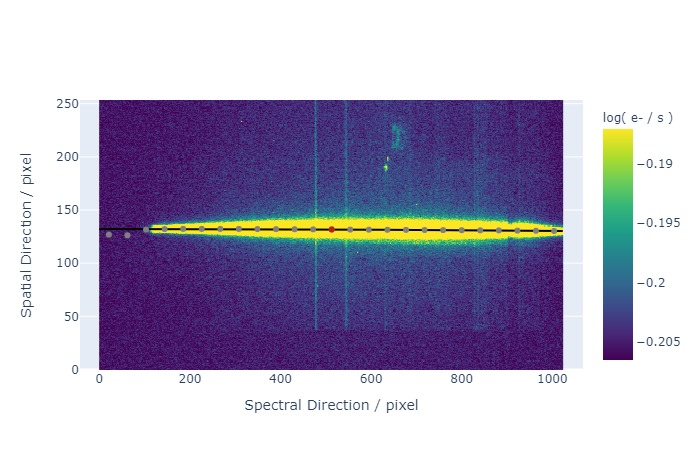

In [7]:
hilt102_twodspec.ap_trace(nspec=1, resample_factor=10, display=True, renderer='jpg')

c:\users\cylam\git\aspired\aspired\twodspec.py:2584: RuntimeWarning:

invalid value encountered in sqrt



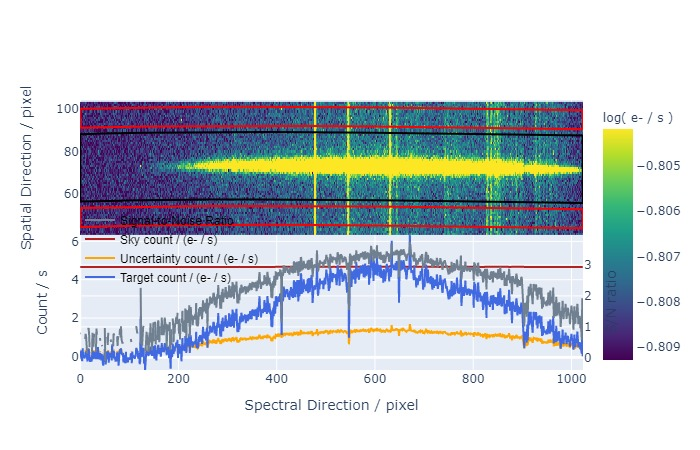

c:\users\cylam\git\aspired\aspired\twodspec.py:2584: RuntimeWarning:

invalid value encountered in sqrt



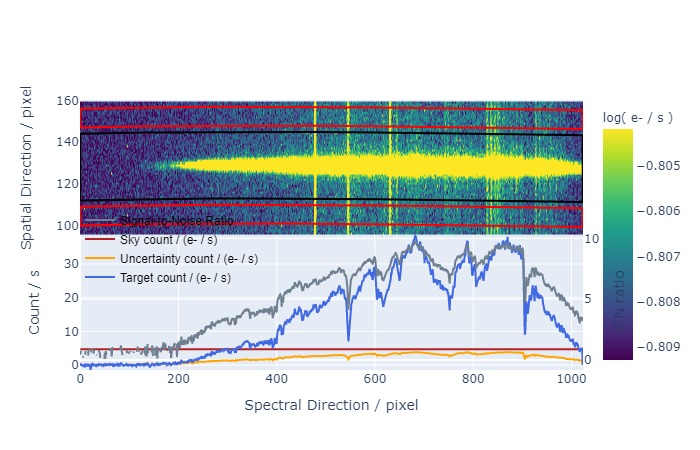

In [8]:
# Uncomment this to supply trace(s) manually, this overwrites the traces found with ap_trace.
# All these should work
#lhs6328_twodspe.add_trace([np.ones(1024)*130., np.ones(1024)*70.], 5.)
#lhs6328_twodspe.add_trace(np.ones(1024)*130., 5.)
#lhs6328_twodspe.add_trace([np.ones(1024)*130.], 5.)
#lhs6328_twodspe.add_trace([np.ones(1024)*130.], [5.])

# Optimal extracting spectrum by summing over the aperture along the trace
lhs6328_twodspec.ap_extract(apwidth=15,
                            skywidth=10,
                            skydeg=1,
                            optimal=False,
                            display=True,
                            save_iframe=False,
                            renderer='jpg')

c:\users\cylam\git\aspired\aspired\twodspec.py:2708: RuntimeWarning:

invalid value encountered in true_divide

c:\users\cylam\git\aspired\aspired\twodspec.py:2746: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\cylam\git\aspired\aspired\twodspec.py:2749: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\cylam\git\aspired\aspired\twodspec.py:2737: RuntimeWarning:

divide by zero encountered in true_divide



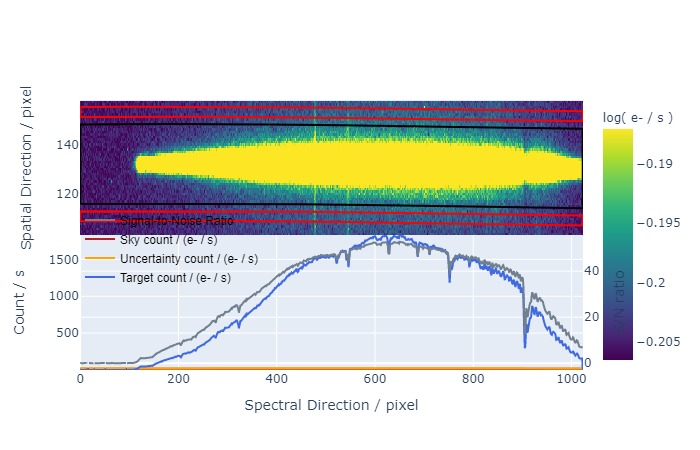

In [9]:
hilt102_twodspec.ap_extract(apwidth=15,
                            skysep=3,
                            skywidth=5,
                            skydeg=1,
                            optimal=True,
                            display=True,
                            save_iframe=True,
                            renderer='jpg')

In [24]:
# Extract the 1D arc by aperture sum of the traces provided
lhs6328_twodspec.extract_arc_spec(display=False, renderer='jpg')
hilt102_twodspec.extract_arc_spec(display=False, renderer='jpg')

In [25]:
lhs6328_onedspec = spectral_reduction.OneDSpec()
lhs6328_onedspec.from_twodspec(lhs6328_twodspec, stype='science')
# The standard extraction is identical to above, so we are reusing it
lhs6328_onedspec.from_twodspec(hilt102_twodspec, stype='standard')

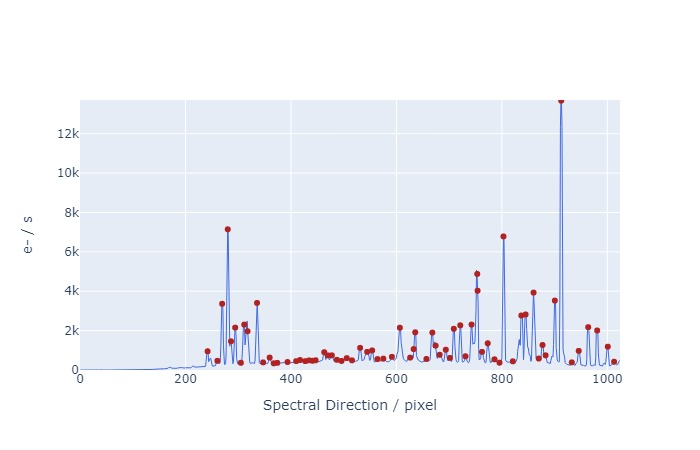

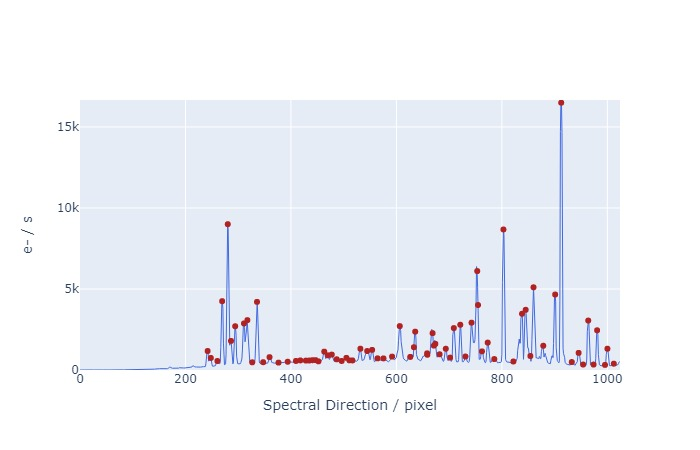

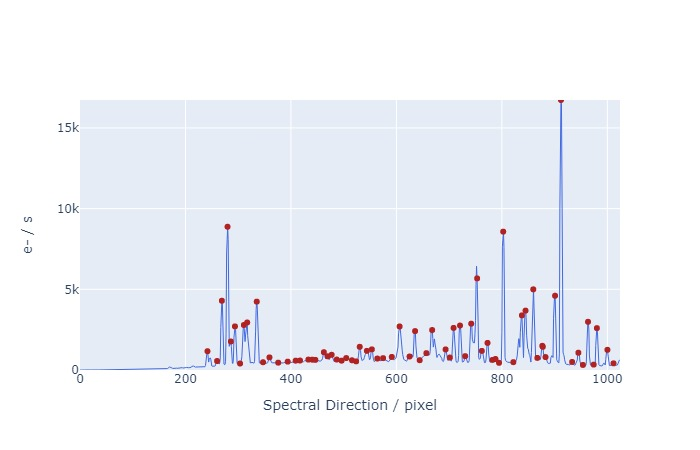

In [26]:
# Find the peaks of the arc
lhs6328_onedspec.find_arc_lines(display=True, stype='science+standard', renderer='jpg')

In [28]:
# Configure the wavelength calibrator
lhs6328_onedspec.initialise_calibrator(stype='science+standard')
lhs6328_onedspec.set_hough_properties(num_slopes=500,
                                      xbins=100,
                                      ybins=100,
                                      min_wavelength=3500,
                                      max_wavelength=8000,
                                      stype='science+standard')
lhs6328_onedspec.add_user_atlas(elements=element,
                                 wavelengths=atlas,
                                 stype='science+standard')
lhs6328_onedspec.do_hough_transform()

In [29]:
lhs6328_onedspec.fit(max_tries=500, stype='science', display=False)

Most inliers: 23, best error: 1.2428: 100%|██████████| 500/500 [00:37<00:00, 13.30it/s]


In [30]:
lhs6328_onedspec.add_fit_coeff(
    fit_coeff=lhs6328_onedspec.science_spectrum_list[0].fit_coeff,
    fit_type=lhs6328_onedspec.science_spectrum_list[0].fit_type,
    stype='standard')

In [31]:
lhs6328_onedspec.apply_wavelength_calibration(stype='science')
lhs6328_onedspec.apply_wavelength_calibration(stype='standard')


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



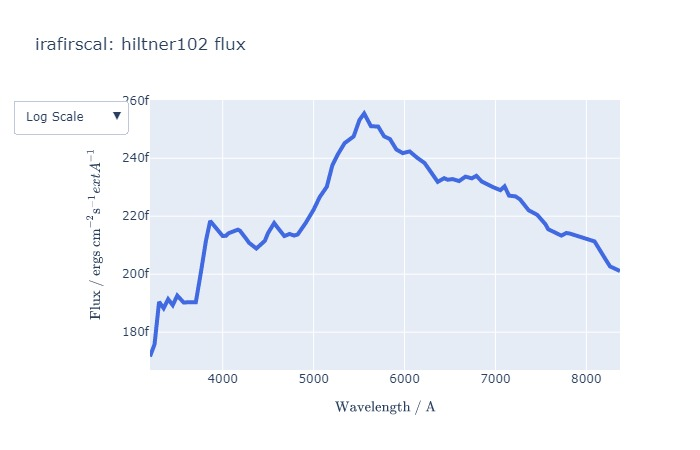

In [32]:
lhs6328_onedspec.load_standard(
    target='hiltner102',
    library='irafirs',
    cutoff=0.4,
    ftype='flux'
)
lhs6328_onedspec.inspect_standard(renderer='jpg')


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



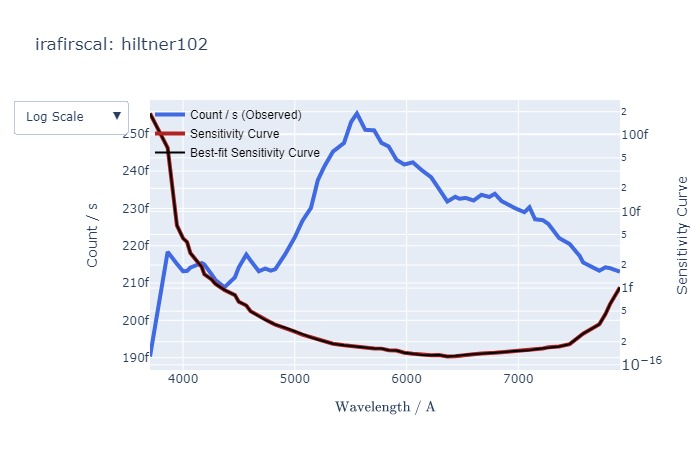

In [33]:
# Get the sensitivity curves
lhs6328_onedspec.compute_sensitivity(k=3)
lhs6328_onedspec.inspect_sensitivity(renderer='jpg')

In [34]:
lhs6328_onedspec.apply_flux_calibration(stype='science')


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



In [35]:
lhs6328_onedspec.apply_flux_calibration(stype='standard')

In [36]:
lhs6328_onedspec.inspect_reduced_spectrum(stype='science')

In [37]:
lhs6328_onedspec.inspect_reduced_spectrum(stype='standard')